In [1]:
from kth_dataset import KTH_Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from LSTMscratch import LSTMscratch_GRU
import torch
import torch.nn as nn
from Model_Wrapper import Wrapper
import helper 


In [2]:
# Create a dataset and a DataLoader
transforms1 = {'val':transforms.Compose([
    transforms.Resize([32, 32]),  # Resize the image first
    transforms.ToTensor(),        # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for a single channel
]),
'train':transforms.Compose([
    transforms.Resize([32, 32]),  # Resize the image first
    transforms.RandomHorizontalFlip(p=0.5),       # Random horizontal flip
    transforms.ToTensor(),        # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for a single channel
])
}



# Initialize dataset
test_dataset = KTH_Dataset(root_dir="/home/nfs/inf6/data/datasets/kth_actions/processed", sequence_length=50,split="test", transform=transforms1["val"],use_saved_samples=True)
train_dataset = KTH_Dataset(root_dir="/home/nfs/inf6/data/datasets/kth_actions/processed", sequence_length=50,split="train", transform=transforms1["train"],use_saved_samples=True)

In [3]:
train_dataset.__len__()

281330

In [4]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=8,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=8,pin_memory=True)
print("test_dataset per epoch",next(iter(test_loader))[0].size())

test_dataset per epoch torch.Size([32, 15, 1, 32, 32])


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
classes = ["Boxing","HandClapping","HandWaving","Jogging","Running","Walking"]


# LSTM scratch

  0%|          | 0/5623 [00:00<?, ?it/s]

Epoch 1 Iter 5623: loss 0.98456.: 100%|██████████| 5623/5623 [07:15<00:00, 12.91it/s]

Accuracy/train 32.31645560629145
Loss/train 1.2696657704645558


Accuracy/test 39.278021620742905
Loss/test 1.2865074562352097


Epoch 2 Iter 5623: loss 0.62158.: 100%|██████████| 5623/5623 [07:14<00:00, 12.94it/s]

Accuracy/train 50.83004296553425
Loss/train 0.9233534333970058


Accuracy/test 40.99406648784849
Loss/test 1.6728989728453953


Epoch 3 Iter 5623: loss 0.70062.: 100%|██████████| 5623/5623 [07:15<00:00, 12.92it/s]

Accuracy/train 57.74354397630522
Loss/train 0.7723797063227122


Accuracy/test 48.79805738437779
Loss/test 1.6245171476064082


Epoch 4 Iter 5623: loss 0.65135.: 100%|██████████| 5623/5623 [07:20<00:00, 12.76it/s]

Accuracy/train 69.67478701507348
Loss/train 0.5896033504568723


Accuracy/test 50.851418353247176
Loss/test 1.7755644416360443


Epoch 5 Iter 5623: loss 0.74497.: 100%|██████████| 5623/5623 [07:19<00:00, 12.81it/s]

Accuracy/train 76.24487396853313
Loss/train 0.47672027177219606


Accuracy/test 53.0287328293912
Loss/test 1.863193716092824


Epoch 6 Iter 5623: loss 0.69104.: 100%|██████████| 5623/5623 [07:17<00:00, 12.85it/s]

Accuracy/train 79.08741379516337
Loss/train 0.42009183862774097


Accuracy/test 53.2867999674876
Loss/test 1.965598208531159


Epoch 7 Iter 5623: loss 0.27223.: 100%|██████████| 5623/5623 [08:05<00:00, 11.57it/s]

Accuracy/train 80.87414536531219
Loss/train 0.3830614429382631


Accuracy/test 52.627407949280666
Loss/test 1.8350382326613315


Epoch 8 Iter 5623: loss 0.53910.: 100%|██████████| 5623/5623 [07:33<00:00, 12.39it/s]

Accuracy/train 82.12214109765512
Loss/train 0.35780634819168056


Accuracy/test 53.644436316345605
Loss/test 1.8420525744490353


Epoch 9 Iter 5623: loss 0.26140.: 100%|██████████| 5623/5623 [07:19<00:00, 12.79it/s]

Accuracy/train 83.56127816556122
Loss/train 0.3331865538504599


Accuracy/test 55.254815898561326
Loss/test 1.9312920842492263


Epoch 10 Iter 5623: loss 0.10514.: 100%|██████████| 5623/5623 [07:17<00:00, 12.87it/s]

Accuracy/train 84.84520582451584
Loss/train 0.3104887687758992


Accuracy/test 52.79809802487198
Loss/test 2.083398250236303
Validation accuracy: 52.8%


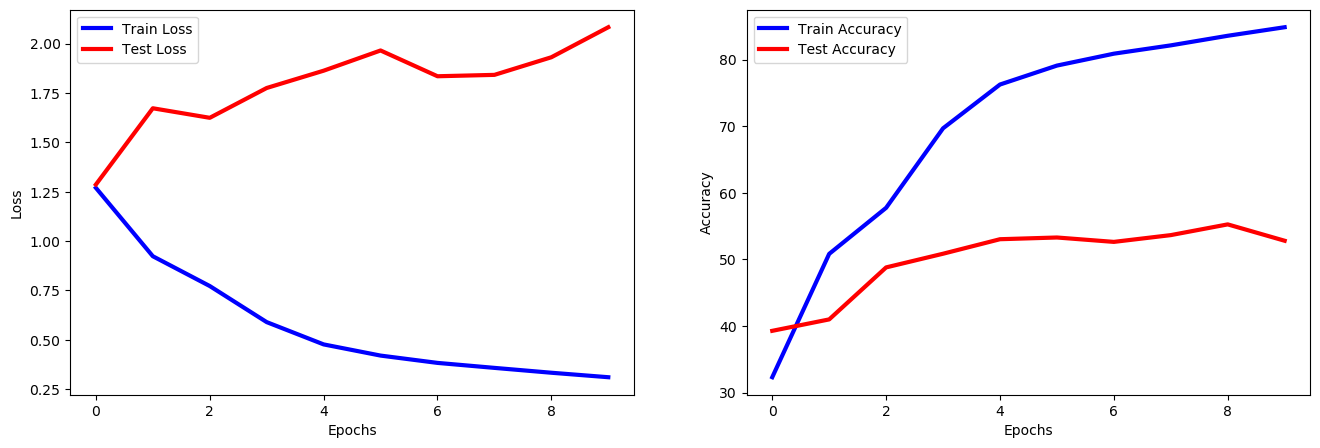

In [ ]:
writer = helper.new_writer("models","LSTMscratch")
model = LSTMscratch_GRU(input_dim=64, hidden_dim=16, number_of_layers=3,device=device,dropout=0.5).to(device)

# classification loss function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

train = Wrapper(model_name="LSTMscratch", model = model, device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= True)
train.train(10,train_loader,test_loader,classes)
writer.close()
train.valid_accuracy()
train.plot_loss_acc()


# LSTM using nn.lstmcell

Epoch 1 Iter 5623: loss 0.82848.: 100%|██████████| 5623/5623 [06:45<00:00, 13.87it/s]

Accuracy/train 36.2026221299167
Loss/train 1.1439670770379884


Accuracy/test 43.385759570836385
Loss/test 1.202994409035431


Epoch 2 Iter 5623: loss 0.91474.: 100%|██████████| 5623/5623 [07:21<00:00, 12.72it/s]

Accuracy/train 54.535061869106556
Loss/train 0.8208684076326673


Accuracy/test 50.271275298707636
Loss/test 1.3593347433909668


Epoch 3 Iter 5623: loss 0.34879.: 100%|██████████| 5623/5623 [06:28<00:00, 14.48it/s]

Accuracy/train 65.62669926017935
Loss/train 0.6444987423390696


Accuracy/test 54.863651141997885
Loss/test 1.1704656413570258


Epoch 4 Iter 5623: loss 0.78119.: 100%|██████████| 5623/5623 [06:31<00:00, 14.35it/s]

Accuracy/train 75.05816654931324
Loss/train 0.5025309443940222


Accuracy/test 55.8278468666179
Loss/test 1.2494221889570085


Epoch 5 Iter 5623: loss 0.40389.: 100%|██████████| 5623/5623 [06:26<00:00, 14.53it/s]

Accuracy/train 77.98882000950525
Loss/train 0.4410762118260758


Accuracy/test 60.30033325205235
Loss/test 1.2910254118080797


Epoch 6 Iter 5623: loss 0.38182.: 100%|██████████| 5623/5623 [06:30<00:00, 14.40it/s]

Accuracy/train 80.00722146252134
Loss/train 0.40103238744841085


Accuracy/test 59.40014630577908
Loss/test 1.4850383430717637


Epoch 7 Iter 5623: loss 0.04904.: 100%|██████████| 5623/5623 [06:30<00:00, 14.39it/s]

Accuracy/train 81.32747328987452
Loss/train 0.37232093689438184


Accuracy/test 58.88706006665041
Loss/test 1.470669381597648


Epoch 8 Iter 5623: loss 0.16654.: 100%|██████████| 5623/5623 [06:34<00:00, 14.25it/s]

Accuracy/train 82.31706574330923
Loss/train 0.3507886069929305


Accuracy/test 62.743842965130455
Loss/test 1.4982354095596908


Epoch 9 Iter 5623: loss 0.34474.: 100%|██████████| 5623/5623 [06:33<00:00, 14.29it/s]

Accuracy/train 83.15753087786385
Loss/train 0.3343216348681271


Accuracy/test 62.09969113224417
Loss/test 1.5797720790301006


Epoch 10 Iter 5623: loss 0.13540.: 100%|██████████| 5623/5623 [06:32<00:00, 14.32it/s]

Accuracy/train 83.98639262987824
Loss/train 0.3159072506773992


Accuracy/test 59.92644070551898
Loss/test 1.7082304023072468
Validation accuracy: 59.93%


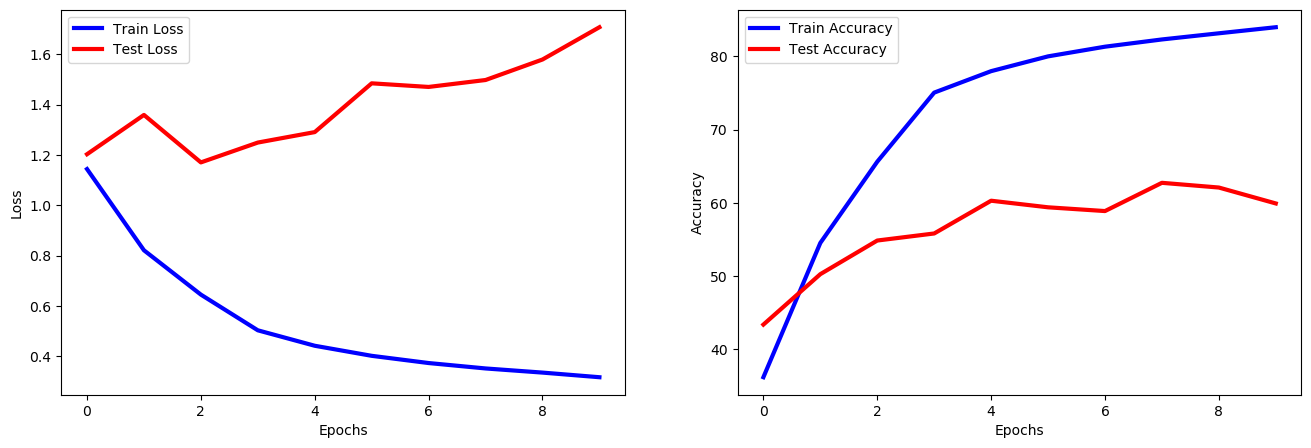

In [ ]:
writer = helper.new_writer("models","LSTM")
model_1 = LSTMscratch_GRU(input_dim=64, hidden_dim=16, number_of_layers=3,device=device,use_custom=False,dropout = 0.5).to(device)

# classification loss function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_1.parameters(), lr=3e-4)
# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

train = Wrapper(model_name="LSTMcell", model = model_1, device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= True)
train.train(10,train_loader,test_loader,classes)
writer.close()
train.valid_accuracy()
train.plot_loss_acc()


# CONV LSTM 

In [ ]:
from ConvLSTMscratch import ConvLSTM

model = ConvLSTM(input_dim=1, hidden_dim=4, kernel_size=3, num_layers=2,batch_first=True).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
classes = ["Boxing","HandClapping","HandWaving","Jogging","Running","Walking"]
writer = helper.new_writer("models","ConvLSTMscratch")
train = Wrapper(model_name="ConvLSTM", model = model, device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= True)
train.train(10,train_loader,test_loader,classes)
writer.close()
train.valid_accuracy()
train.plot_loss_acc()


<img src="/home/user/elwakeely1/Cuda_Vision_Lab-/Session4/solution/Convlstmmodel.png" alt="Convlstmmodel" style="width:1000px;">


# 3D_ResNet 

Epoch 1 Iter 8792: loss 0.01704.: 100%|██████████| 8792/8792 [13:45<00:00, 10.65it/s]

Accuracy/train 81.64395311766262
Loss/train 0.2193815095437246


Accuracy/test 91.80428678064906
Loss/test 0.24053730379350569


Epoch 2 Iter 8792: loss 0.00096.: 100%|██████████| 8792/8792 [13:38<00:00, 10.74it/s]

Accuracy/train 97.2849737972963
Loss/train 0.05713445093768859


Accuracy/test 94.520669676181
Loss/test 0.1571929413198499


Epoch 3 Iter 8792: loss 0.00519.: 100%|██████████| 8792/8792 [13:35<00:00, 10.78it/s]

Accuracy/train 98.91613572781347
Loss/train 0.03200730680753394


Accuracy/test 94.87363594355384
Loss/test 0.1549192636935852


Epoch 4 Iter 8792: loss 0.00000.: 100%|██████████| 8792/8792 [13:34<00:00, 10.79it/s]

Accuracy/train 99.20950162594346
Loss/train 0.02472624401443399


Accuracy/test 95.5418903067572
Loss/test 0.13291385350448964


Epoch 5 Iter 8792: loss 0.00077.: 100%|██████████| 8792/8792 [13:34<00:00, 10.79it/s]

Accuracy/train 99.43179260151851
Loss/train 0.019524458877305348


Accuracy/test 93.34518181495041
Loss/test 0.18079444633475672


Epoch 6 Iter 8792: loss 0.00732.: 100%|██████████| 8792/8792 [13:35<00:00, 10.79it/s]

Accuracy/train 99.42775126958004
Loss/train 0.017704565791504808


Accuracy/test 96.13621014466996
Loss/test 0.1228452610153498


Epoch 7 Iter 8792: loss 0.00289.: 100%|██████████| 8792/8792 [13:33<00:00, 10.81it/s]

Accuracy/train 99.58730637783817
Loss/train 0.015277580441112883


Accuracy/test 94.34862972310098
Loss/test 0.16019788199843268


Epoch 8 Iter 8792: loss 0.00006.: 100%|██████████| 8792/8792 [13:37<00:00, 10.76it/s]

Accuracy/train 99.58847068299366
Loss/train 0.014044504588987275


Accuracy/test 95.97661109728789
Loss/test 0.13713702934297237


Epoch 9 Iter 8792: loss 0.02139.: 100%|██████████| 8792/8792 [13:33<00:00, 10.80it/s]

Accuracy/train 99.67174305886577
Loss/train 0.011933983123769249


Accuracy/test 96.62780364696265
Loss/test 0.09379488620615861


Epoch 10 Iter 8792: loss 0.00000.: 100%|██████████| 8792/8792 [13:33<00:00, 10.81it/s]

Accuracy/train 99.66142828660949
Loss/train 0.012475725033502175


Accuracy/test 96.85813812959869
Loss/test 0.11088210772341918
Validation accuracy: 96.86%


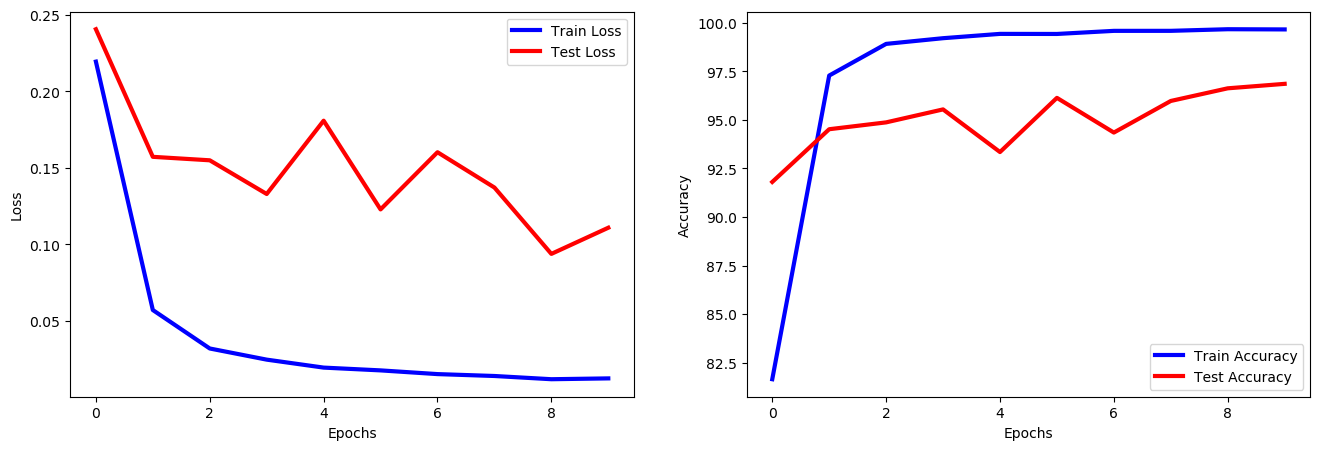

In [9]:
import torchvision.models as models

model = models.video.r3d_18(pretrained=True).to(device)
model.stem[0] = nn.Conv3d(in_channels =1,out_channels = 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3))
# Modify the final layer to match the number of classes to 6 for KTH Actions
model.fc = nn.Linear(model.fc.in_features, 6)
model = model.to(device)

# classification loss function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

writer = helper.new_writer("models","3D_ResNet")
train = Wrapper(model_name="3D_ResNet", model = model, device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= True)

train.train(10,train_loader,test_loader,classes)

writer.close()

train.valid_accuracy()
train.plot_loss_acc()


# GRU model 

  0%|          | 0/1406 [00:00<?, ?it/s]

Epoch 1 Iter 1406: loss 1.10109.: 100%|██████████| 1406/1406 [06:28<00:00,  3.62it/s]

Accuracy/train 31.51749738933777
Loss/train 1.302529420486385


Accuracy/test 36.559172559538325
Loss/test 1.5490565256195044


Epoch 2 Iter 1406: loss 0.79821.: 100%|██████████| 1406/1406 [06:24<00:00,  3.65it/s]

Accuracy/train 48.94475017388344
Loss/train 0.9812750389447084


Accuracy/test 39.17743639762659
Loss/test 1.9793148316123241


Epoch 3 Iter 1406: loss 0.84274.: 100%|██████████| 1406/1406 [06:22<00:00,  3.68it/s]

Accuracy/train 53.5032555262667
Loss/train 0.8952387437372764


Accuracy/test 40.4291636186296
Loss/test 2.0892716262475024


Epoch 4 Iter 1406: loss 0.97571.: 100%|██████████| 1406/1406 [06:27<00:00,  3.63it/s]

Accuracy/train 56.38359394850831
Loss/train 0.8539268709348242


Accuracy/test 42.323010647809475
Loss/test 1.9039866055406736


Epoch 5 Iter 1406: loss 0.81789.: 100%|██████████| 1406/1406 [06:23<00:00,  3.66it/s]

Accuracy/train 58.67783218410412
Loss/train 0.804993092717012


Accuracy/test 43.55136958465415
Loss/test 1.6024039154230425


Epoch 6 Iter 1406: loss 0.68688.: 100%|██████████| 1406/1406 [06:31<00:00,  3.60it/s]

Accuracy/train 61.9816158527233
Loss/train 0.7559569154999843


Accuracy/test 43.17646102576607
Loss/test 1.7178009694284107


Epoch 7 Iter 1406: loss 0.89267.: 100%|██████████| 1406/1406 [06:24<00:00,  3.66it/s]

Accuracy/train 64.37784634635831
Loss/train 0.7127517814698973


Accuracy/test 42.65118263838088
Loss/test 1.998464850845846


Epoch 8 Iter 1406: loss 0.62979.: 100%|██████████| 1406/1406 [06:22<00:00,  3.68it/s]

Accuracy/train 65.61453655787858
Loss/train 0.6834788647179583


Accuracy/test 42.863529220515325
Loss/test 1.9924827644342018


Epoch 9 Iter 1406: loss 0.64910.: 100%|██████████| 1406/1406 [06:29<00:00,  3.61it/s]

Accuracy/train 67.42835553209738
Loss/train 0.6584079983520983


Accuracy/test 45.234902056409005
Loss/test 1.7162757274904057


Epoch 10 Iter 1406: loss 0.68681.: 100%|██████████| 1406/1406 [06:25<00:00,  3.65it/s]

Accuracy/train 68.72067286191405
Loss/train 0.6373766664929614


Accuracy/test 44.40786799967488
Loss/test 1.9434200766245724
Validation accuracy: 44.41%


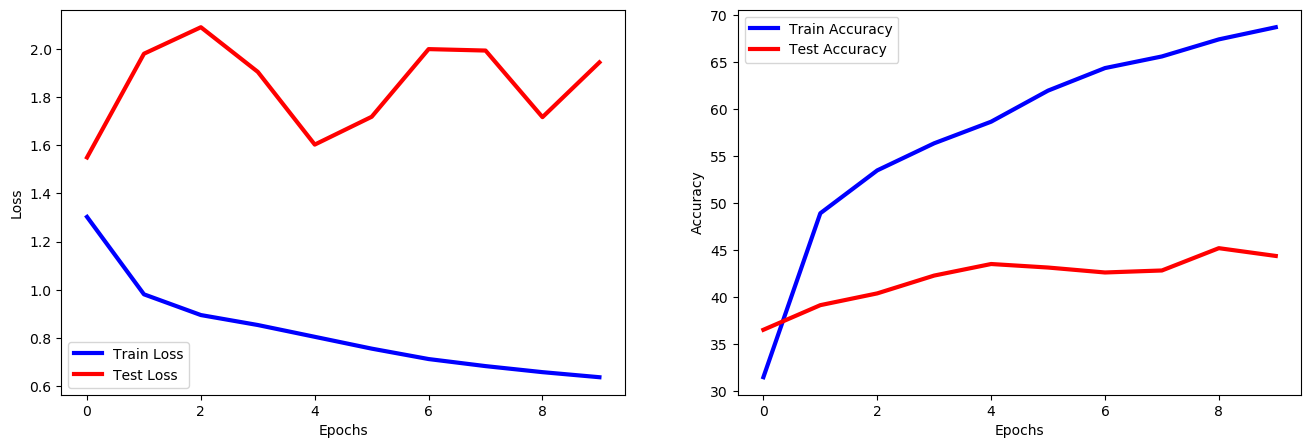

In [ ]:
writer = helper.new_writer("models","GRU")
model_1 = LSTMscratch_GRU(input_dim=64, hidden_dim=16, number_of_layers=2,device=device,GRU=True,dropout=0.5).to(device)

# classification loss function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_1.parameters(), lr=3e-4)
# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

train = Wrapper(model_name="LSTMcell", model = model_1, device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= True)
train.train(10,train_loader,test_loader,classes)
writer.close()
train.valid_accuracy()
train.plot_loss_acc()

The ConvLSTM achieved the best results on the KTH Action Dataset because it combines convolutional layers with LSTM mechanisms. The convolutional layers are excellent for extracting spatial features (like textures and shapes in video frames), while the LSTMs handle temporal patterns, such as motion across frames. This combination makes ConvLSTMs especially effective for action recognition, where understanding both appearance and movement is crucial.

In contrast:

-GRU performed well but didn't capture spatial patterns as effectively because it lacks built-in convolutional layers.
-The standard LSTM also struggled with spatial information, as it’s not designed to process structured data like images -directly.

ConvLSTM's ability to process both spatial and temporal information makes it more suited for tasks involving motion analysis.